<a href="https://colab.research.google.com/github/nasy-sr/Project-Tugas-Kelompok-Neural-Networks/blob/notebooks/Dataset_3_%E2%80%93_Air_Quality_Dataset_(Italy).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
import matplotlib.pyplot as plt

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/Dataset3_ML/data.csv"

def load_air_quality(path):
    # Coba format umum AirQualityUCI: sep=';' decimal=','
    try:
        df_try = pd.read_csv(path, sep=";", decimal=",")
        # Kalau cuma 1 kolom berarti kemungkinan salah separator
        if df_try.shape[1] <= 1:
            raise ValueError("Separator tidak cocok, coba default CSV.")
        return df_try
    except Exception:
        # Fallback: CSV biasa
        return pd.read_csv(path)

df = load_air_quality(file_path)

print("Loaded:", file_path)
display(df.head())
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

Loaded: /content/drive/MyDrive/Dataset3_ML/data.csv


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-07-02,183.820007,187.300003,183.419998,187.179993,182.199005,17731300
1,2018-07-03,187.789993,187.949997,183.539993,183.919998,179.025772,13954800
2,2018-07-05,185.259995,186.410004,184.279999,185.399994,180.466370,16604200
3,2018-07-06,185.419998,188.429993,185.199997,187.970001,182.967972,17485200
4,2018-07-09,189.500000,190.679993,189.300003,190.580002,185.508545,19756600


Shape: (503, 7)

Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [ ]:
df = df.loc[:, ~df.columns.astype(str).str.contains("^Unnamed")]
df = df.dropna(axis=1, how="all")
df = df.replace(-200, np.nan)

In [ ]:
if "Date" in df.columns and "Time" in df.columns:
    # Gabung jadi datetime (format sering: dd/mm/yyyy dan HH.MM.SS atau HH:MM:SS)
    dt_str = df["Date"].astype(str) + " " + df["Time"].astype(str)
    dt = pd.to_datetime(dt_str, errors="coerce", dayfirst=True)

    df["hour"] = dt.dt.hour
    df["day"] = dt.dt.day
    df["month"] = dt.dt.month
    df["weekday"] = dt.dt.weekday

    # Drop kolom raw Date/Time biar aman
    df = df.drop(columns=["Date", "Time"], errors="ignore")

In [ ]:
TARGET = "Close"  # ganti kalau kamu mau target lain, misal "NO2(GT)" atau "O3(GT)"

# Kalau kolom target tidak ada, kasih info jelas
if TARGET not in df.columns:
    print("\n[WARNING] Kolom TARGET tidak ditemukan.")
    print("Kolom yang tersedia:", df.columns.tolist())
    raise ValueError(f"TARGET '{TARGET}' tidak ada. Ganti variabel TARGET sesuai kolom dataset kamu.")

# Drop baris yang target-nya kosong
df = df.dropna(subset=[TARGET])

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(float)

print("\nRingkas target:")
print(y.describe())


Ringkas target:
count    503.000000
mean     229.792386
std       52.074283
min      142.190002
25%      191.529999
50%      215.460007
75%      266.330002
max      366.529999
Name: Close, dtype: float64


In [ ]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("\nNumerik:", num_cols)
print("Kategorikal:", cat_cols)


Numerik: ['Open', 'High', 'Low', 'Adj Close', 'Volume']
Kategorikal: ['Date']


In [ ]:
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    # Kalau error "sparse_output", ganti jadi: OneHotEncoder(handle_unknown="ignore", sparse=False)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=SEED
)

X_train_p = preprocess.fit_transform(X_train)
X_test_p  = preprocess.transform(X_test)

X_train_p = X_train_p.astype(np.float32)
X_test_p  = X_test_p.astype(np.float32)

n_features = X_train_p.shape[1]
print("\nn_features:", n_features)


n_features: 357


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(n_features,)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="linear")
])

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │        45,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,145 (211.50 KB)

 Trainable params: 54,145 (211.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
]

history = model.fit(
    X_train_p, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 3608.9490 - mae: 49.4764 - val_loss: 6174.8687 - val_mae: 68.3432
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 3461.5142 - mae: 48.8799 - val_loss: 6043.0693 - val_mae: 67.6370
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 3191.0657 - mae: 47.8811 - val_loss: 5910.0845 - val_mae: 66.8995
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3169.0288 - mae: 47.0181 - val_loss: 5770.6528 - val_mae: 66.0980
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3205.8159 - mae: 46.5061 - val_loss: 5641.4443 - val_mae: 65.3798
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2887.2107 - mae: 43.5690 - val_loss: 5520.3813 - val_mae: 64.7099
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 2562.3848 - mae: 41.4776 - val_loss: 5393.6753 - val_mae: 63.9670
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2306.0859 - mae: 38.9673 - val_loss: 5261.8848 - val_mae: 63.1578
Epoch 9/50
5/5 

In [ ]:
y_pred = model.predict(X_test_p).ravel()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nHasil Evaluasi (Regresi):")
print(f"MAE : {mae:.4f}")
print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2  : {r2:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Hasil Evaluasi (Regresi):
MAE : 43.4922
MSE : 2668.5884
RMSE: 51.6584
R2  : 0.0061


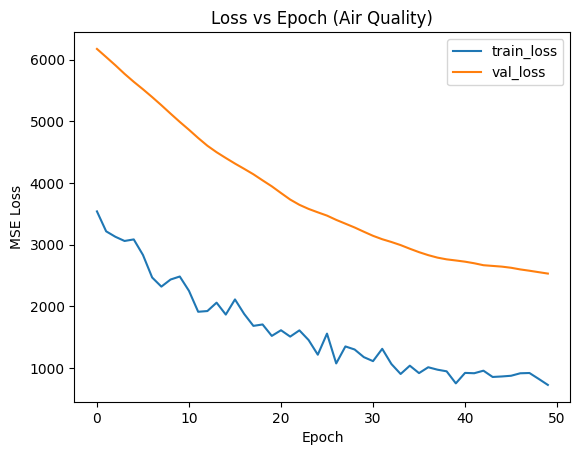

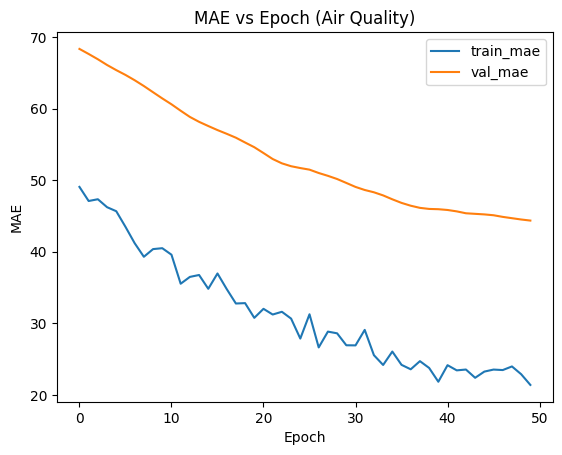

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss vs Epoch (Air Quality)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["mae"], label="train_mae")
plt.plot(history.history["val_mae"], label="val_mae")
plt.title("MAE vs Epoch (Air Quality)")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()